Importer les bibliothèques nécessaires.

objectif un modèle prédictif pour estimer la probabilité de survie des passagers

Features

1.Je pense que les femmes ont un taux de survie plus élevé que les hommes

2.Je suppose que les passagers de première classe ont plus de chances de survivre que ceux de troisième classe

3.Je pense que la survie dépend de l'âge

    Je suppose que les passagers plus jeunes avaient plus de chances de survivre que les passagers plus âges
    
    Je suppose que les femmes ont survécu en plus grand nombre que les hommes, en particulier dans les tranches d'âge entre 20 et 40 ans
    
    Je suppose que les enfants avaient un taux de survie plus élevé, surtout chez les filles

4.Je suppose que les enfants (moins de 18 ans) avaient un taux de survie plus élevé que les adultes, car ils ont peut être été priorisés pendant l'évacuation 

    On observe que 53.85% des enfants ont survécu, ce qui est supérieur à la moyenne générale.Cela semble confirmer l'hypothèse

5.Je pense que l'âge dépend du titre

In [42]:
!pip  install pandas
!pip install plotly

In [43]:
import pandas as pd
import plotly as pt
import plotly as pt
from collections import Counter #compte automatiquement combien des elements apparaît
import numpy as np

Charger les données et vérification de types et les valeurs manquantes

In [44]:
df = pd.read_csv('../titanic-project/titanic_data/gender_submission.csv')
test = pd.read_csv('../titanic-project/titanic_data/test.csv')
train = pd.read_csv('../titanic-project/titanic_data/train.csv')
print(train.dtypes)
train['Age'] = train['Age'].fillna(train['Age'].median())
print(train.isna().sum())

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Sex et classe 

Le nombre total et le nombre de survivants et morts pour les hommes et les femmes sur un graphique.

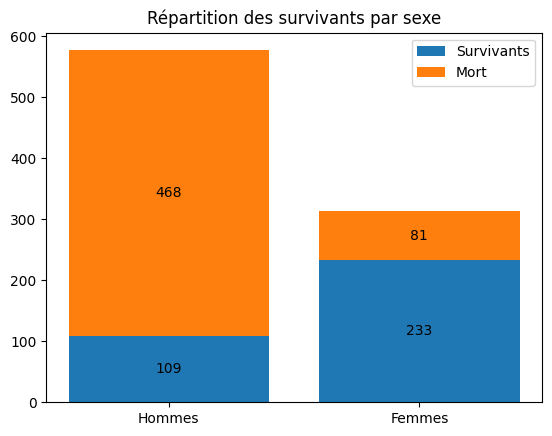

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
train = pd.read_csv('../titanic-project/titanic_data/train.csv')

# Compter le nombre total d'hommes et de femmes et le nombre de survivants
males_total = len(train.loc[(train['Sex'] == 'male')])
females_total = len(train.loc[(train['Sex'] == 'female')])
# print(f"Males total: {males_total}\nFemales total: {females_total}")
males_total_survived = len(train.loc[(train['Sex'] == 'male') & (train['Survived'] == 1)])
females_total_survived = len(train.loc[(train['Sex'] == 'female') & (train['Survived'] == 1)])
# print(f"Males Survivants: {males_total_survived}\nFemales Survivants: {females_total_survived}")

count = {
    "Survivants": [males_total_survived, females_total_survived],
    "Mort": [males_total-males_total_survived, females_total-females_total_survived]
}
# print(count)

fig, ax = plt.subplots()
x = np.zeros(2) # list = [0,0 hommes ; 0,0 femmes]
ax.set_title("Répartition des survivants par sexe")
for key, count in count.items():
    i = ax.bar(('Hommes', 'Femmes'),count, width=0.8, bottom=x, label=key)
    x+=count
    ax.legend()
    ax.bar_label(i, label_type="center")

plt.show()



Le nombre total et le nombre de survivants et morts par class sur un graphique


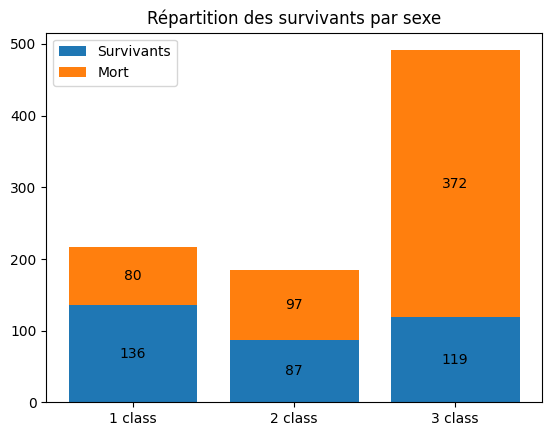

In [46]:
train = pd.read_csv('../titanic-project/titanic_data/train.csv')

# Compter le nombre total d'hommes et de femmes par class et le nombre de survivants par class
first_class_total = len(train.loc[(train['Pclass'] == 1)])
second_class_total = len(train.loc[(train['Pclass'] == 2)])
third_class_total = len(train.loc[(train['Pclass'] == 3)])
first_class_total_survived = len(train.loc[(train['Pclass'] == 1) & (train['Survived'] == 1)])
second_class_total_survived = len(train.loc[(train['Pclass'] == 2) & (train['Survived'] == 1)])
third_class_total_survived = len(train.loc[(train['Pclass'] == 3) & (train['Survived'] == 1)])

count = {
    "Survivants": [first_class_total_survived, second_class_total_survived, third_class_total_survived],
    "Mort": [first_class_total-first_class_total_survived, second_class_total-second_class_total_survived, third_class_total-third_class_total_survived]
}
# print(count)

#Visualiser
fig, ax = plt.subplots()
x = np.zeros(3) # list = [0,0 1 class ; 0,0 2 class; 0, 0; 3 class]
ax.set_title("Répartition des survivants par sexe")
for key, count in count.items():
    i = ax.bar(('1 class', '2 class', '3 class'),count, width=0.8, bottom=x, label=key)
    x+=count
    ax.legend()
    ax.bar_label(i, label_type="center")

plt.show()


Examinez la répartition des passagers par âge et la répartition des survivants, hommes et femmes, par âge.

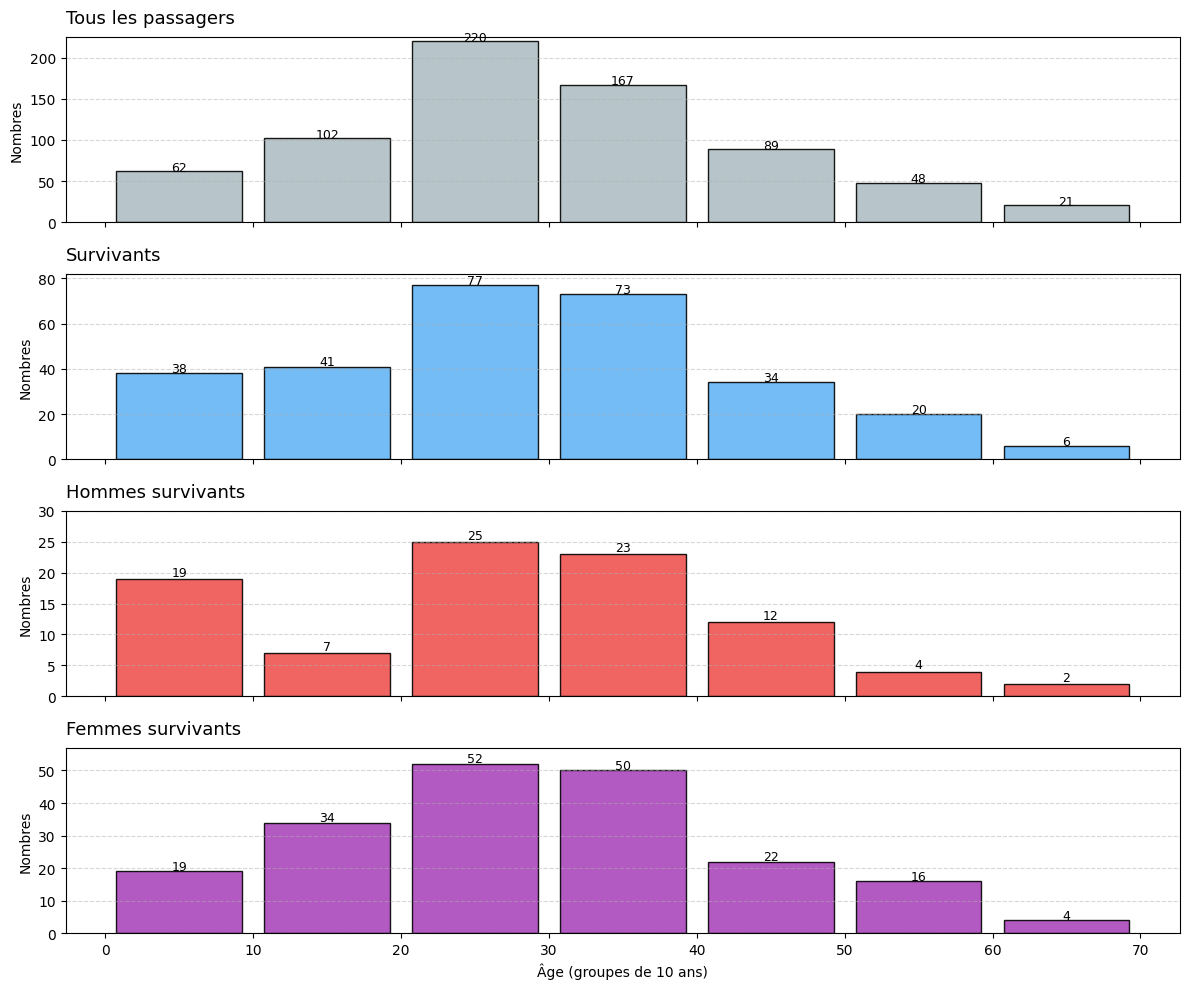

In [47]:
# groupes
groups = {
    'Tous les passagers': train,
    'Survivants': train[train['Survived'] == 1],
    'Hommes survivants': train[(train['Survived'] == 1) & (train['Sex'] == 'male')],
    'Femmes survivants': train[(train['Survived'] == 1) & (train['Sex'] == 'female')],
}
bins = np.arange(0, 80, 10)
colors = ['#B0BEC5', '#64B5F6', '#EF5350', '#AB47BC']

#Visualiser
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

for ax, (title, data), color in zip(axs, groups.items(), colors):
    ages = data['Age'].dropna()
    counts, edges, _ = ax.hist(ages, bins=bins, color=color, edgecolor='black', alpha=0.9, rwidth=0.85)
    
    for i, count in enumerate(counts):
        if count > 0:
            ax.text(edges[i] + 5, count + 0.5, f'{int(count)}', ha='center', fontsize=9)
    
    ax.set_title(title, fontsize=13, loc='left', pad=10)
    ax.set_ylabel('Nombres')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_ylim(0, max(counts) + 5)

axs[-1].set_xlabel('Âge (groupes de 10 ans)')
axs[-1].set_xticks(bins)

plt.tight_layout()
plt.show()

# from collections import Counter

# #Sélectionnons les listes de passagers en groupes distincts
# survivors = train.loc[(train['Survived'] == 1)]
# male_survivors = train.loc[((train['Sex'] == 'male') & (train['Survived'] == 1))]
# female_survivors = train.loc[((train['Sex'] == 'female') & (train['Survived'] == 1))]

# #Nombre d'âges
# num_of_ages = len(dict(Counter(survivors['Age'])).keys())

# #Visualiser
# fig, axs = plt.subplots(2,2)
# fig.set_figwidth(20)
# fig.set_figheight(10)
# psgrs = [['Tous les passagers', 'Survivants Total'], ['Hommes survivants', 'Femmes survivants']]
# for i, surv in enumerate([[train, survivors], [male_survivors, female_survivors]]):
#     for j, subsurv in enumerate(surv):
#         axs[i][j].hist(subsurv['Age'], bins=num_of_ages, rwidth=0.8)
#         axs[i][j].set_title(psgrs[i][j])
#         axs[i][j].set_xlabel('Age')
#         axs[i][j].set_ylabel('Nombre de passagers')
#         axs[i][j].set_ylim(0,30)
#         axs[i][j].set_xlim(0,70)
# plt.show()

Les passagers âgés de moins de 18 ans

Les passagers âgés de moins de 18 ans: 53.85%


<Axes: >

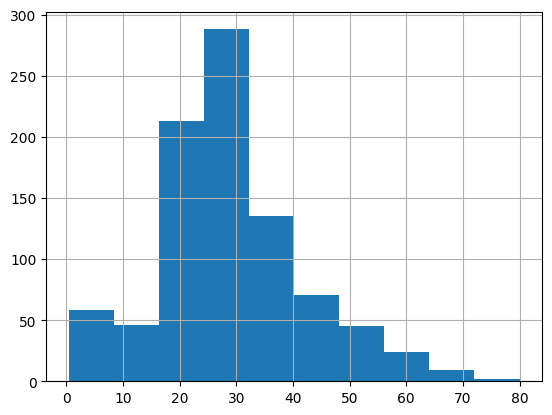

In [70]:
enfants = train.loc[((train['Age'] > 0) & (train['Age'] < 18))]
enfants_survivants = train.loc[((train['Age'] > 0) & (train['Age'] < 18) & (train['Survived'] == 1))]
print(f"Les passagers âgés de moins de 18 ans: {round(len(enfants_survivants)*100/len(enfants), 2)}%")
train.loc[((train['Age'] > 0 & (train['Age'] < 18) & (train['Survived'] == 1)))].Age.hist()

Noms et âges

Représentons la dépendance de l'âge par rapport au titre sous la forme d'un ensemble de diagrammes en boîte.

/tmp/ipykernel_960/4292307209.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(ages.values(), labels=titles)


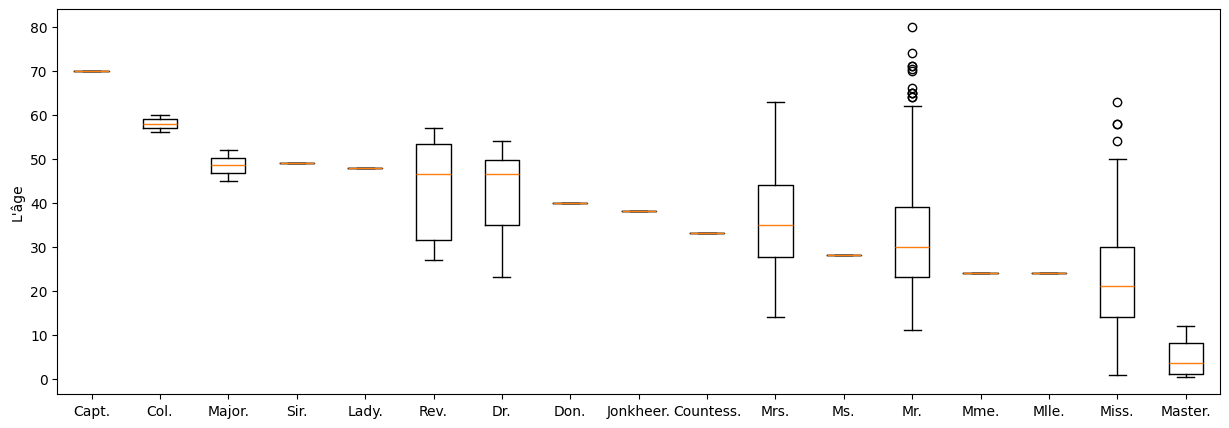

In [49]:
titles = ("Capt.","Col.","Major.","Sir.","Lady.","Rev.","Dr.","Don.","Jonkheer.","Countess.","Mrs.","Ms.","Mr.","Mme.","Mlle.","Miss.","Master.")

#Créons une liste de titres pour chaque passagers
titled_names = []
for names in train.Name:
    for title in titles:
        if title in names.split(' '):
            titled_names.append(title)
            break
# print(titled_names)

#delete the column Title and recreate
#Ajouter une nouvelle colonne au dataframe - Titre
train.insert(12, 'Title', titled_names)
# print(train['Title'])
# train = train.drop('Title', axis=1)

#Créer un dictionnaire avec des paires de titre : liste des âges
ages = dict.fromkeys(titles, [])
for i, title in enumerate(train.Title):
    if not pd.isna(train.Age[i]):
        ages[title] = ages[title] + [train.Age[i]]

#Visualiser
fig, ax = plt.subplots(figsize=(15, 5))
ax.boxplot(ages.values(), labels=titles)
ax.set_ylabel("L'âge")
plt.show()

Utilisons la médiane des passagers titulaires du même âge pour reconstituer les âges.

In [50]:
for i, age in enumerate(train.Age):
    if pd.isna(age):
        train.Age[i] = np.median(ages[train.Title[i]])
# print(train['Age'].isna().sum()) #verifier les missing values

/tmp/ipykernel_960/4196232690.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train.Age[i] = np.median(ages[train.Title[i]])
/tmp/ipykernel_960/4196232690.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

Taux de survie en fonction du titre

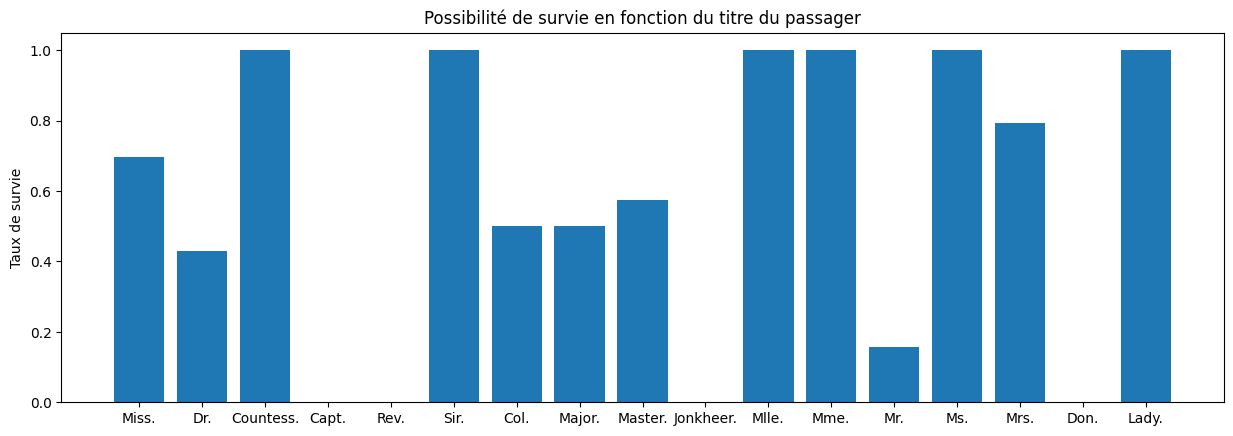

In [51]:
# Groupes à fusionner
aristocratic = ("Capt.", "Col.", "Don.", "Dr.","Jonkheer.", "Lady.", "Major.","Rev.", "Sir.", "Countess.")
mrs = ("Ms.")
miss = ("Mlle.", 'Mme.')

# Combinaison de titres
for i, title in enumerate(train.Title):
    if title in aristocratic:
        train.Title[i] == 'aristocratic'
    elif title in mrs:
        train.Title[i] == 'mrs'
    elif title in miss:
        train.Title[i] == 'miss'
    
title_survive = dict.fromkeys(set(train.Title))
#Il faut regarder le pourcentage de survivants, car le nombre de personnes varie beaucoup.
for title in title_survive.keys():
    title_survive[title] = len(train.loc[((train['Title'] == title) & (train['Survived'] == 1))]) / len(train.loc[(train['Title'] == title)])

fig, ax = plt.subplots()
ax.bar(title_survive.keys(), title_survive.values())
ax.set_ylabel('Taux de survie')
ax.set_title('Possibilité de survie en fonction du titre du passager')
fig.set_figwidth(15)
plt.show()

Taux de survie en fonction de la cabines

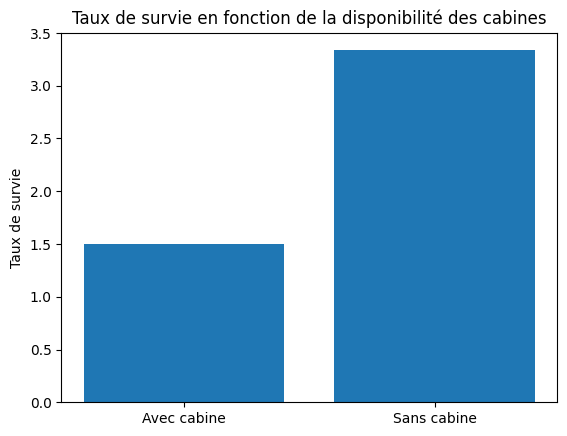

In [ ]:
# Regroupons les passagers
have_cabin = train.loc[(pd.notna(train['Cabin']))]
have_cabin_survived = train.loc[((pd.notna(train['Cabin'])) & (train['Survived'] == 1))]
no_cabin = train.loc[(pd.isna(train['Cabin']))]
no_cabin_survived = train.loc[((pd.isna(train['Cabin'])) & (train['Survived'] == 1))]

# Visualiser la proportion de survivants
fig, ax = plt.subplots()
ax.bar(('Avec cabine', 'Sans cabine'), (len(have_cabin)/len(have_cabin_survived), len(no_cabin_survived)/len(no_cabin)))
ax.set_ylabel('Taux de survie')
ax.set_title('Taux de survie en fonction de la disponibilité des cabines')
plt.show()